#install and import required packages

In [19]:
#hazm package used for Persian text processing and NLP tasks in Python

!pip install hazm #Version: 0.9.3

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hazm
import string

from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from hazm import Normalizer, Stemmer, stopwords_list, Lemmatizer

#Download data directly from Kegel

In [21]:
# Make sure the kaggle.json is present.
!ls -lha kaggle.json

# Install the Kaggle API client.
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

# Replace with your dataset's API command
!kaggle datasets download -d soheiltehranipour/snappfood-persian-sentiment-analysis

#unzip dataset
!unzip snappfood-persian-sentiment-analysis.zip

-rw-r--r-- 1 root root 67 Sep 23 11:31 kaggle.json
snappfood-persian-sentiment-analysis.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  snappfood-persian-sentiment-analysis.zip
replace Snappfood - Sentiment Analysis.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


#Read and explore data

In [26]:
df = pd.read_csv('Snappfood - Sentiment Analysis.csv', delimiter='\t')
print('shape of dataset: ', df.shape, '\n', '-------------', '\n')
print(df.info(), '\n', '-------------', '\n')
df.sample(3)

shape of dataset:  (70000, 4) 
 ------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  520 non-null    object 
 1   comment     70000 non-null  object 
 2   label       70000 non-null  object 
 3   label_id    69480 non-null  float64
dtypes: float64(1), object(3)
memory usage: 2.1+ MB
None 
 ------------- 



,Unnamed: 0,comment,label,label_id
28850,NaN,مثل همیشه یه برگر خوشمزه با نان تازه و گوشت و ...,HAPPY,0.0
36279,NaN,من برا شام می‌خاستم واسه صبحانه دستم رسید,SAD,1.0
62130,NaN,بسیار عالی و خوشمزه من که مشتری دائمی شما هستم...,HAPPY,0.0


In [27]:
#drop unwanted columns
df.drop(df.columns[0], axis=1, inplace=True)
df.sample(3)

,comment,label,label_id
13130,شیرینی کره ایشو اصلا اصلا پیشنهاد نمیکنم مونده...,SAD,1.0
5384,متاسفانه با اینکه شکلات جدید اورده شد باز هم ب...,SAD,1.0
55146,غذاها میتونست عالی باشه اگه ظرف یه بار مصرف پل...,SAD,1.0


In [ ]:
#Check for null data
df.isnull().sum()

comment       0
label         0
label_id    520
dtype: int64

In [28]:
#See rows containing null values
df[df['label_id'].isnull()].head(3)

,comment,label,label_id
21,SAD,1,NaN
89,SAD,1,NaN
161,SAD,1,NaN


In [29]:
#Drop rows containing null values
df.dropna(axis=0, inplace=True)
df.isnull().sum()

comment     0
label       0
label_id    0
dtype: int64

####Data distribution visualization

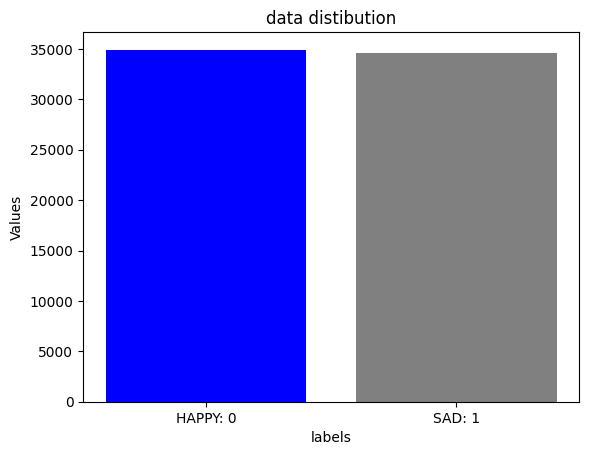

In [35]:
count_label = list(df['label_id'].value_counts())

colors = ['blue','Gray']
plt.bar([0, 1], count_label, color= colors)

# Customize the tick markers or labels on the horizontal axis
new_labels = ['HAPPY: 0', 'SAD: 1']
plt.xticks([0, 1], new_labels)

# Add labels and title to the plot
plt.xlabel('labels')
plt.ylabel('Values')
plt.title('data distibution')

plt.show()

In [36]:

df['words_count'] = df['comment'].apply(lambda t: len(hazm.word_tokenize(t)))

min_max_len = df['words_count'].min() , df['words_count'].max()
print(f'Text Min: {min_max_len[0]} \tMax: {min_max_len[1]}')

Text Min: 2 	Max: 378


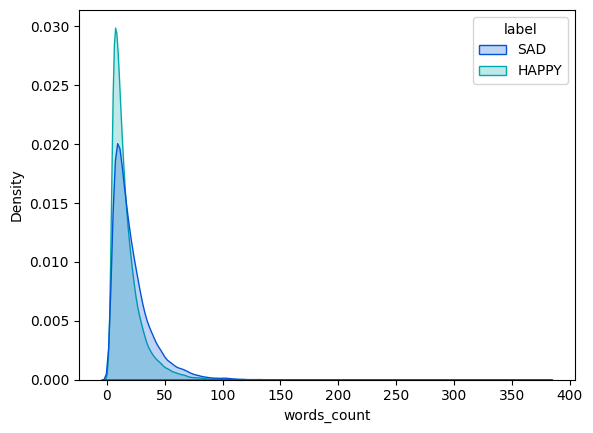

In [37]:
sns.kdeplot(x = df['words_count'], hue=df['label'], palette='winter', fill=True, warn_singular=False)
plt.show()

#data preprosessing

In [39]:
normalizer = Normalizer()
lemmatizer = Lemmatizer()
stemmer = Stemmer()
stopwords = stopwords_list()
punctuations = string.punctuation + "," + "،"

def normalize_text(text):
  #remove punctuation
  translator = str.maketrans('', '', punctuations)
  #text normalization
  normalized_text = normalizer.normalize(text)

  #cleaned_text = [stemmer.stem(word.translate(translator)) for word in hazm.word_tokenize(normalized_text) if word not in stopwords]

  cleaned_text = [word.translate(translator) for word in hazm.word_tokenize(normalized_text)]
  #convert list of token to sentence
  return ' '.join(cleaned_text)

In [40]:
#apply text normalization to 'comment' column
df['normalized_comment'] = df['comment'].apply(normalize_text)

In [41]:
#assign data
X, y =df['normalized_comment'], df['label_id']

#spliting data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
#TfidfVectorizer: Convert a collection of raw documents to a matrix of TF-IDF features. Equivalent to CountVectorizer followed by TfidfTransformer.
tokenizer = hazm.WordTokenizer().tokenize

tfidf = TfidfVectorizer(use_idf=True, max_features=378, min_df=1, tokenizer=tokenizer)

X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


#Model definition and their training

In [43]:
def train_model(model):
  cv_scores = cross_val_score(model, X_train, y_train, cv=5)
  #y_pred = model.predict(X_test)
  #return print(classification_report(y_test, y_pred))
  return print('accuracy:', cv_scores.mean())

In [ ]:
'''
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter grid
param_grid = {
    'n_estimators': randint(100, 1000),  # Number of trees
    'max_depth': randint(5, 50),         # Maximum depth
    'min_samples_split': randint(2, 10),  # Minimum samples required to split
    'min_samples_leaf': randint(1, 10),   # Minimum samples required at leaf nodes
    'max_features': ['sqrt', 'log2'],     # Number of features to consider
    'class_weight': [None, 'balanced']    # Class weights
}

# Create a Random Forest model
rf = RandomForestClassifier()

# Perform Randomized Search
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=10, cv=3, verbose=2, random_state=42)
random_search.fit(X_train, y_train)  # X_train and y_train are your training data

# Print the best parameters and best score
print("Best Parameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)

>>>Best Parameters:  {'class_weight': 'balanced', 'max_depth': 48, 'max_features': 'log2', 'min_samples_leaf': 6, 'min_samples_split': 3, 'n_estimators': 291}
>>>Best Score:  0.8343228267127231

'''

In [ ]:
#Random Forest model

rf = RandomForestClassifier()
train_model(rf)

accuracy: 0.8382988273861489


In [ ]:
# XGBoost model

xgb = XGBClassifier()
train_model(xgb)

accuracy: 0.8399538870523127


In [ ]:
#  Support Vector Classifier model

svc = SVC(C=0.1)

train_model(svc)

accuracy: 0.838262807613728


In [ ]:
'''
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform

# Define the logistic regression model
model = LogisticRegression()

# Define the hyperparameter search space
param_dist = {
    'C': uniform(loc=0, scale=10),  # Regularization parameter
    'penalty': ['l1', 'l2', 'elasticnet'],  # Penalty type
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],  # Solver algorithm
    'max_iter': [100, 500, 1000]  # Maximum number of iterations
}

# Perform random search cross-validation
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings to sample
    cv=5,  # Number of cross-validation folds
    scoring='accuracy',  # Scoring metric to evaluate the models
    random_state=42
)

# Fit the random search to your training data
random_search.fit(X_train, y_train)

# Print the best hyperparameters found
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate the best model on your test set
best_model = random_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

>>>Best Hyperparameters: {'C': 6.011150117432088, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
>>>Test Accuracy: 0.8392343120322395

'''

In [ ]:
#Logistic Regressian model

lr = LogisticRegression(max_iter=100)
train_model(lr)

accuracy: 0.841411140616524


In [ ]:
# Naive Bayes model

nb = MultinomialNB()
train_model(nb)

accuracy: 0.825975075599281


In [ ]:
# k-nearest Neighbors model

knn = KNeighborsClassifier(n_neighbors=7)
train_model(knn)

accuracy: 0.73960141247485
